In [1]:
import requests
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Comment this out if you don't have dotenv installed and/or you'd rather just hardcode your api key. I put mine inside a .env - Ademide :)
import os
from dotenv import load_dotenv


### Part 1

**Problem Motivation:**
Young adults, often college graduates, consider many options when relocating to a new city for their first full-time job. A critical part of this is understanding public transit accessibility in potential cities. Decisions about where to live and how to commute impacts monthly expenses, career opportunities, and quality of life. With rising housing costs and environmental concerns, understanding which cities offer comprehensive, efficient public transit has become increasingly important for young professionals. This model examines transit route data from major US cities to help college students identify locations with robust transportation networks. By analyzing route diversity, coverage density, and system efficiency, the model predicts insights to inform relocation decisions.

**Key Questions:**

- Which cities offer the most comprehensive transit coverage, measured by total routes and diversity of transportation types (subway, bus, ferry, rail)?
- How does transit system efficiency vary across cities, and can we quantify "transit richness" to compare systems objectively?
- What characteristics distinguish "Transit-Rich" cities from "Transit-Limited" ones, and which cities provide the best value for car-free living?
- Can we predict a city's transit category based on route characteristics such as the number of routes, transit type diversity, and route priority rankings?

**Data Sources:**

- **API**: Transit.land REST API (https://transit.land/api/v2/rest/routes)
- APTAAdmin (2025). *Public Transportation Facts - American Public Transportation Association*. [online] American Public Transportation Association. Available at: https://www.apta.com/news-publications/public-transportation-facts/ [Accessed 27 Oct. 2025].
- **Coverage**: 4 major US cities with 50 routes per city (200 total observations)

**Summary of the Data Processing Pipeline**

- API data collection to retrieve transit route information
- Clean the data to prepare the data frame for visualization and analysis
- Merge and engineer features to create city-level transit metrics
- Visualize using plotting libraries, such as Seaborn, Plotly, and Matplotlib

To process the data, we will first acquire transit route datasets from the Transit.land API. This involves making API calls with bounding box coordinates for each city (Boston, New York, Chicago, San Francisco) to successfully collect route data, then saving the datasets as cleaned .csv files for import into our Jupyter Notebook. Cleaning consists of replacing missing route names with "Unknown", filling missing route sort orders with 999, removing duplicate routes based on city and route_id_numeric, and standardizing route types as integers with missing values set to 3 (bus). Then, we can address key questions, including calculating city-level summary statistics such as total routes per city, route type diversity (number of unique transit types), and average route priority. We will also create a composite "transit richness score" weighted by route count (50%), transit type diversity (30%), and route priority efficiency (20%). We can then merge the individual route data with city-level summaries and classify cities as "Transit-Rich" or "Transit-Limited" based on the median transit richness score. Next, we will perform exploratory data analysis to create visualizations including bar charts comparing total routes across cities, pie charts showing transit type distribution, and scatter plots examining the relationship between route diversity and system efficiency using imported libraries Seaborn, Matplotlib, and Plotly. This process will help us address questions related to transit coverage, system efficiency, and geographical variation in city transportation options. Finally, the cleaned data will be prepared for machine learning by selecting relevant features for predictive modeling of transit category classification based on route characteristics.

### Part 2

**Obtaining data**

In [ ]:
#load_dotenv() # comment this out if you aren't putting the api key in a .env

# If you don't feel like installing dotenv just replace the api-key stuff with: api_key = "your_api_key_here" and remove before commit pls
api_key = os.getenv('TRANSITLAND_API_KEY')

base_url = "https://transit.land/api/v2/rest/routes"

In [4]:
# cities and coordinates
cities = [
    {"name": "Boston", "bbox": "-71.191155,42.227926,-70.986166,42.400819"},
    {"name": "New York", "bbox": "-74.259090,40.477399,-73.700272,40.917577"},
    {"name": "Chicago", "bbox": "-87.940101,41.643919,-87.523985,42.023131"},
    {"name": "San Francisco", "bbox": "-122.515,37.703,-122.357,37.812"}
]

# empty dict for the transit info
transit_dict = {
    'city': [],
    'route_name': [],
    'route_type': [],  # categorical route type
    'route_id_numeric': [],  # numeric value of the routeID
    'route_sort_order': [] # numeric value of route order
}


In [ ]:
for city in cities:
    params = {
        "bbox": city['bbox'], 
        "limit": 50,
        "apikey": api_key
    }
    
    response = requests.get(base_url, params=params)
    data = response.json()
    
    # organize cols
    for route in data.get('routes', []):
        transit_dict['city'].append(city['name'])
        transit_dict['route_name'].append(route.get('route_long_name', route.get('route_short_name', 'Unknown')))
        
        # obtain categorical route type (0=tram, 1=subway, 2=rail, 3=bus, ...) to measure variability
        transit_dict['route_type'].append(route.get('route_type', 3))
        
        # obtain numeric value of the routeID
        route_id = route.get('id', 0)
        transit_dict['route_id_numeric'].append(route_id if isinstance(route_id, int) else hash(str(route_id)) % 10000)
        
        # obtain numeric value of route order, which notes priority of routes to measure efficiency
        transit_dict['route_sort_order'].append(route.get('route_sort_order', 999))

# convert to df
transit_df = pd.DataFrame(transit_dict)
display(transit_df.head(30))

,city,route_name,route_type,route_id_numeric,route_sort_order
0,Boston,Alewife Shuttle Route A,3,145185,1.0
1,Boston,Alewife Shuttle Route B,3,145186,2.0
2,Boston,Alewife Shuttle Route C,3,145187,3.0
3,Boston,Alewife Shuttle Route D,3,145188,4.0
4,Boston,Hartwell Area Shuttle (AM),3,145189,5.0
5,Boston,Hartwell Area Shuttle (PM),3,145190,6.0
6,Boston,Georges Island Ferry,4,141395,0.0
7,Boston,Long Wharf Ferry,4,141397,0.0
8,Boston,Lovells Island Ferry,4,141398,0.0
9,Boston,Peddocks Island Ferry,4,141399,0.0


**Cleaning data**

In [6]:
# lists unnamed routes as having an unknown name
transit_df['route_name'] = transit_df['route_name'].replace('', 'Unknown')
transit_df.loc[transit_df['route_name'].isna(), 'route_name'] = 'Unknown'\

# sets the route sor torder to a float and replaces any missing sort orders with 999
transit_df['route_sort_order'] = transit_df['route_sort_order'].fillna(999)
transit_df['route_sort_order'] = transit_df['route_sort_order'].astype(float)

# removes duplicate routes
transit_df = transit_df.drop_duplicates(subset=['city', 'route_id_numeric'], keep='first')

# makes all route types ints and replaces missing route types with 3
transit_df['route_type'] = transit_df['route_type'].fillna(3)
transit_df['route_type'] = transit_df['route_type'].astype(int)

display(transit_df.head(30))

,city,route_name,route_type,route_id_numeric,route_sort_order
0,Boston,Alewife Shuttle Route A,3,145185,1.0
1,Boston,Alewife Shuttle Route B,3,145186,2.0
2,Boston,Alewife Shuttle Route C,3,145187,3.0
3,Boston,Alewife Shuttle Route D,3,145188,4.0
4,Boston,Hartwell Area Shuttle (AM),3,145189,5.0
5,Boston,Hartwell Area Shuttle (PM),3,145190,6.0
6,Boston,Georges Island Ferry,4,141395,0.0
7,Boston,Long Wharf Ferry,4,141397,0.0
8,Boston,Lovells Island Ferry,4,141398,0.0
9,Boston,Peddocks Island Ferry,4,141399,0.0


**Merging Data**

In [ ]:
# summarizes some the city statistics
city_summary = transit_df.groupby('city').agg({
    'route_id_numeric': 'count', # total number of routes in each city
    'route_type': 'nunique', # number of different types of transit
    'route_sort_order': 'mean' # average route priority, lower = more priority
}).reset_index()

# renames columns for the city summary
city_summary.columns = [
    'city',
    'total_routes',
    'route_type_diversity',
    'avg_route_priority'
]

# transit richness score
# 50% weight in number of cities
# 30% weight in the number of transit types
# 20% weight in the average priority
city_summary['transit_richness_score'] = (
    (city_summary['total_routes'] / city_summary['total_routes'].max() * 50) +
    (city_summary['route_type_diversity'] / city_summary['route_type_diversity'].max() * 30) +
    ((1 / (city_summary['avg_route_priority'] + 1)) / 
     (1 / (city_summary['avg_route_priority'] + 1)).max() * 20)
)

# classify cities by transit richness score
# above median = transit rich
# below median = transit limited
median_score = city_summary['transit_richness_score'].median()
city_summary['transit_category'] = city_summary['transit_richness_score'].apply(
    lambda x: 'Transit-Rich' if x >= median_score else 'Transit-Limited'
)

display(city_summary)

# merges the route data with the city summary
city_cols = ['city', 'total_routes', 'route_type_diversity', 'transit_richness_score', 'transit_category']
transit_df_merged = transit_df.merge(city_summary[city_cols], on='city', how='left')

display(transit_df_merged.head(30))

,city,total_routes,route_type_diversity,avg_route_priority,transit_richness_score,transit_category
0,Boston,50,2,185.46,70.137295,Transit-Limited
1,Chicago,50,2,941.38,70.027165,Transit-Limited
2,New York,50,3,0.28,100.000000,Transit-Rich
3,San Francisco,50,3,999.00,80.025600,Transit-Rich


,city,route_name,route_type,route_id_numeric,route_sort_order,total_routes,route_type_diversity,transit_richness_score,transit_category
0,Boston,Alewife Shuttle Route A,3,145185,1.0,50,2,70.137295,Transit-Limited
1,Boston,Alewife Shuttle Route B,3,145186,2.0,50,2,70.137295,Transit-Limited
2,Boston,Alewife Shuttle Route C,3,145187,3.0,50,2,70.137295,Transit-Limited
3,Boston,Alewife Shuttle Route D,3,145188,4.0,50,2,70.137295,Transit-Limited
4,Boston,Hartwell Area Shuttle (AM),3,145189,5.0,50,2,70.137295,Transit-Limited
5,Boston,Hartwell Area Shuttle (PM),3,145190,6.0,50,2,70.137295,Transit-Limited
6,Boston,Georges Island Ferry,4,141395,0.0,50,2,70.137295,Transit-Limited
7,Boston,Long Wharf Ferry,4,141397,0.0,50,2,70.137295,Transit-Limited
8,Boston,Lovells Island Ferry,4,141398,0.0,50,2,70.137295,Transit-Limited
9,Boston,Peddocks Island Ferry,4,141399,0.0,50,2,70.137295,Transit-Limited


### Part 3

The first implementation is a bar graph depicting the transit richness for each city.

C:\Users\Caleb\AppData\Local\Temp\ipykernel_7400\3387998785.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Transit Category')


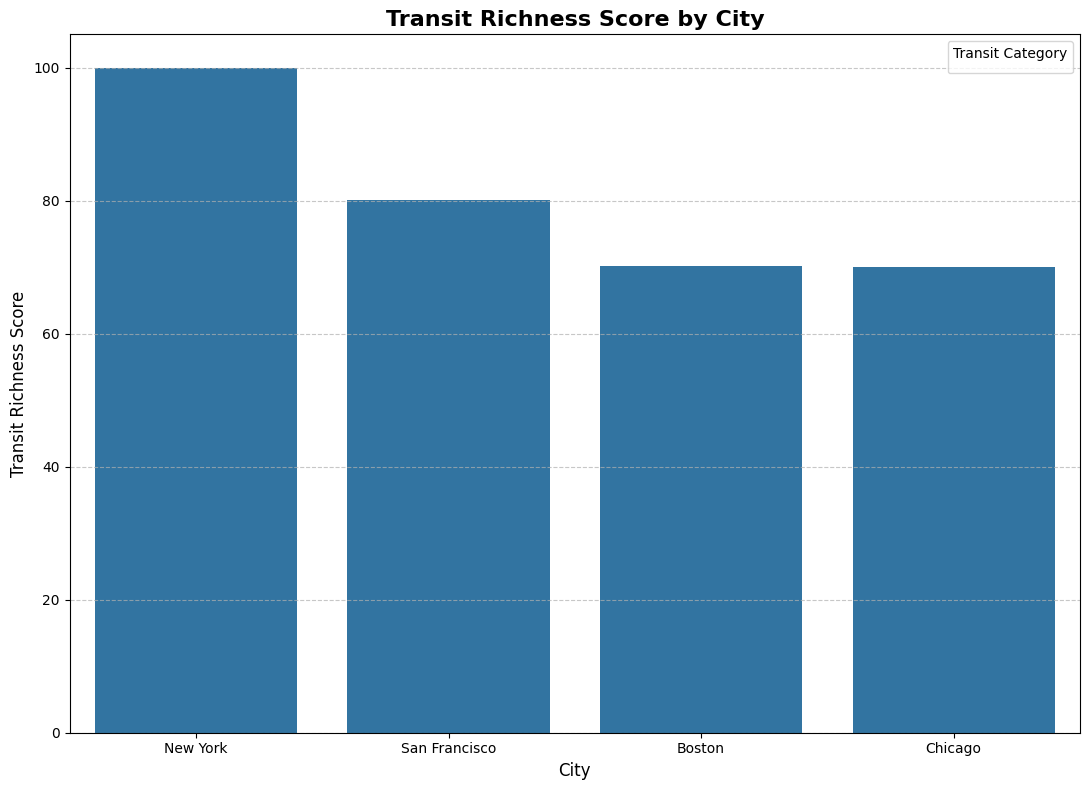

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sorted_summary = city_summary.sort_values('transit_richness_score', ascending=False)

plt.figure(figsize=(11, 8))
sns.barplot(
    data=sorted_summary,
    x='city',
    y='transit_richness_score',
    dodge=False,
)

plt.title('Transit Richness Score by City', fontsize=16, weight='bold')
plt.xlabel('City', fontsize=12)
plt.ylabel('Transit Richness Score', fontsize=12)
plt.legend(title='Transit Category')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


The second implementation includes a scatterplot to show transit diversity versus the total number of routes.

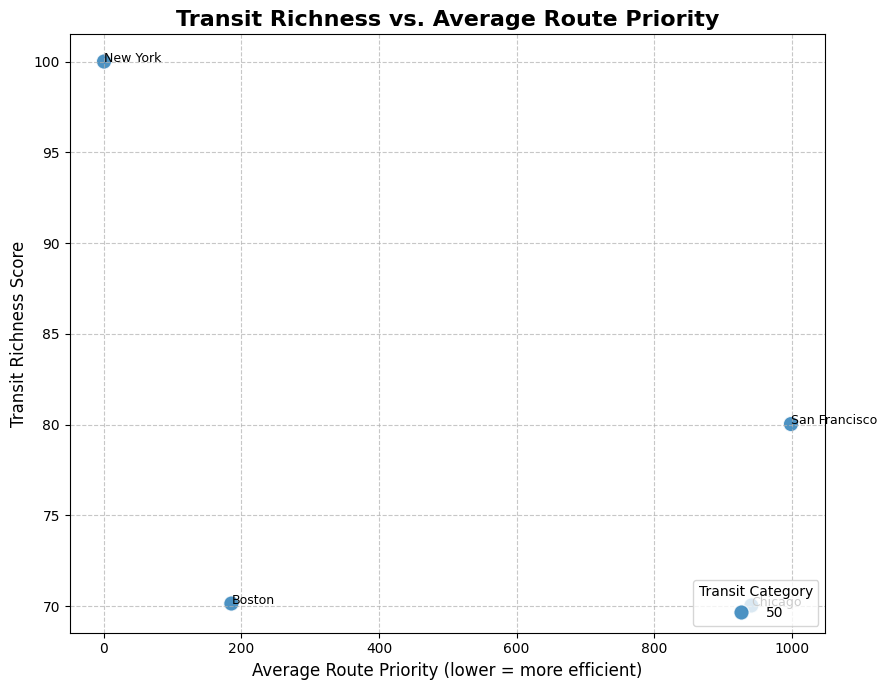

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9, 7))

sns.scatterplot(
    data=city_summary,
    x='avg_route_priority',
    y='transit_richness_score',
    size='total_routes',
    sizes=(120, 620),
    alpha=0.8,
)

# Add city labels
for i, row in city_summary.iterrows():
    plt.text(
        row['avg_route_priority'] + 0.2,
        row['transit_richness_score'],
        row['city'],
        fontsize=9
    )

plt.title('Transit Richness vs. Average Route Priority', fontsize=16, weight='bold')
plt.xlabel('Average Route Priority (lower = more efficient)', fontsize=12)
plt.ylabel('Transit Richness Score', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Transit Category', loc='lower right')
plt.tight_layout()
plt.show()




## Part 3

In [ ]:
def add_bias_column(X):
    """
    Args:
        X (array): can be either 1-d or 2-d
    
    Returns:
        Xnew (array): the same array, but 2-d with a column of 1's in the first spot
    """
    
    # If the array is 1-d
    if len(X.shape) == 1:
        Xnew = np.column_stack([np.ones(X.shape[0]), X])
    
    # If the array is 2-d
    elif len(X.shape) == 2:
        bias_col = np.ones((X.shape[0], 1))
        Xnew = np.hstack([bias_col, X])
        
    else:
        raise ValueError("Input array must be either 1-d or 2-d")

    return Xnew

In [ ]:
def line_of_best_fit(X, y):
    X = add_bias_column(X)
    tXinv = np.linalg.inv(np.matmul(X.T, X))
    m = np.matmul(XtXinv, np.matmul(X.T, y))
    
    return m

In [ ]:
def linreg(X, y, m):
        """
        """
        
        